# Child Mind Institute - Detect Sleep States
## Feature Engineering

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.signal import find_peaks

In [6]:
df = pd.read_csv('data/filtered_train_series.csv')

In [7]:
def add_features(df):
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    
    # Time-Based Features
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['minute_of_hour'] = df['timestamp'].dt.minute
    df['second_of_minute'] = df['timestamp'].dt.second
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_of_month'] = df['timestamp'].dt.day
    df['month_of_year'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year

    # Drop the timestamp column
    df = df.drop(columns=['timestamp'])
    
    # Time of Day Features
    df['time_of_day_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['time_of_day_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    # Rolling Mean and Std
    window = 10
    df['anglez_roll_mean'] = df['anglez'].rolling(window=window, min_periods=1).mean()
    df['enmo_roll_mean'] = df['enmo'].rolling(window=window, min_periods=1).mean()
    df['anglez_roll_std'] = df['anglez'].rolling(window=window, min_periods=1).std(ddof=0)
    df['enmo_roll_std'] = df['enmo'].rolling(window=window, min_periods=1).std(ddof=0)
    
    # Interaction Features
    df['enmo_hour_interaction'] = df['enmo'] * df['hour_of_day']
    df['anglez_hour_interaction'] = df['anglez'] * df['hour_of_day']
    
    # Peaks
    df['enmo_pct_change'] = df['enmo'].pct_change(periods=5) 
    df['anglez_pct_change'] = df['anglez'].pct_change(periods=5)
    df['enmo_peaks'] = df['enmo'].rolling(window=60).apply(lambda x: len(find_peaks(x)[0]))
    df['anglez_peaks'] = df['anglez'].rolling(window=60).apply(lambda x: len(find_peaks(x)[0]))

    # Lag Features
    df['anglez_lag1'] = df['anglez'].shift(1).fillna(df['anglez'])
    df['enmo_lag1'] = df['enmo'].shift(1).fillna(df['enmo'])

    # Interaction Terms
    df['anglez_enmo_product'] = df['anglez'] * df['enmo']
    df['anglez_enmo_ratio'] = df['anglez'] / (df['enmo'] + 1e-6) 

    # Statistical Moments
    df['anglez_skew'] = df['anglez'].rolling(window=window, min_periods=1).skew()
    df['enmo_kurtosis'] = df['enmo'].rolling(window=window, min_periods=1).kurt()
    df['anglez_skew'] = df['anglez_skew'].fillna(0)
    df['enmo_kurtosis'] = df['enmo_kurtosis'].fillna(0)

    # Cumulative Features 
    df['cumulative_enmo'] = df['enmo'].cumsum()
    df['cumulative_max_enmo'] = df['enmo'].cummax()
    
    # Individual features
    df['anglez_mean'] = df.groupby('series_id')['anglez'].transform('mean')
    df['anglez_median'] = df.groupby('series_id')['anglez'].transform('median')
    df['anglez_std'] = df.groupby('series_id')['anglez'].transform('std')
    df['enmo_mean'] = df.groupby('series_id')['enmo'].transform('mean')
    df['enmo_median'] = df.groupby('series_id')['enmo'].transform('median')
    df['enmo_std'] = df.groupby('series_id')['enmo'].transform('std')
    
    # Change point
    df['anglez_change_point'] = df['anglez'].diff().abs()
    df['enmo_change_point'] = df['enmo'].diff().abs()
    
    return df

In [8]:
df = add_features(df)
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df.describe()

,step,anglez,enmo,event,hour_of_day,minute_of_hour,second_of_minute,day_of_week,day_of_month,month_of_year,...,cumulative_max_enmo,cumulative_min_enmo,anglez_mean,anglez_median,anglez_std,enmo_mean,enmo_median,enmo_std,anglez_change_point,enmo_change_point
count,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,...,1.043585e+06,1043585.0,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06,1.043585e+06
mean,2.574270e+05,-9.381043e+00,4.776500e-02,8.386475e-03,1.215166e+01,2.950805e+01,2.733838e+01,3.017962e+00,1.585871e+01,6.529411e+00,...,9.030406e+00,0.0,-9.019121e+00,-9.580399e+00,3.345324e+01,4.121762e-02,1.735955e-02,9.167827e-02,1.978927e+01,4.436827e-02
std,1.807208e+05,3.306907e+01,1.098518e-01,1.127414e-01,7.145388e+00,1.732934e+01,1.734182e+01,1.989364e+00,8.779794e+00,3.685817e+00,...,3.035428e+00,0.0,1.028548e+01,1.145504e+01,5.535793e+00,1.226446e-02,8.269669e-03,4.034225e-02,2.383506e+01,1.256172e-01
min,2.000000e+00,-9.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,1.093200e+00,0.0,-3.269593e+01,-3.519960e+01,1.799115e+01,1.677366e-02,1.000000e-04,1.511465e-02,0.000000e+00,0.000000e+00
25%,1.182580e+05,-2.967940e+01,5.600000e-03,0.000000e+00,6.000000e+00,1.500000e+01,1.000000e+01,1.000000e+00,8.000000e+00,3.000000e+00,...,4.357500e+00,0.0,-1.591580e+01,-1.678155e+01,3.093024e+01,3.227583e-02,1.160000e-02,6.189055e-02,3.074100e+00,2.200000e-03
50%,2.373220e+05,-9.653600e+00,2.240000e-02,0.000000e+00,1.300000e+01,2.900000e+01,2.500000e+01,3.000000e+00,1.600000e+01,6.000000e+00,...,1.091340e+01,0.0,-9.315917e+00,-1.031810e+01,3.462520e+01,4.106205e-02,1.640000e-02,8.987804e-02,1.078190e+01,1.230000e-02
75%,3.587310e+05,8.957800e+00,5.050000e-02,0.000000e+00,1.800000e+01,4.500000e+01,4.000000e+01,5.000000e+00,2.300000e+01,1.000000e+01,...,1.091340e+01,0.0,-3.312487e+00,-3.640700e+00,3.723973e+01,4.740154e-02,2.220000e-02,1.128489e-01,2.785520e+01,3.890000e-02
max,1.433866e+06,9.000000e+01,1.091340e+01,2.000000e+00,2.300000e+01,5.900000e+01,5.500000e+01,6.000000e+00,3.100000e+01,1.200000e+01,...,1.091340e+01,0.0,2.661193e+01,3.004135e+01,4.496410e+01,1.065164e-01,8.270000e-02,2.809647e-01,1.788795e+02,1.035410e+01


In [9]:
def plot_pca(df):

    # Select features
    X = df.drop(columns=['event', 'series_id'])
    feature_names = X.columns

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_ * 100

    # Get loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    # Create a DataFrame for the loadings
    loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'])
    loadings_df['Variable'] = feature_names

    # Create a DataFrame for observations
    scores_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    scores_df['event'] = df['event'].values

    # Separate data based on 'event' values
    event_1 = scores_df[scores_df['event'] == 1]
    event_2 = scores_df[scores_df['event'] == 2]
    other_events = scores_df[~scores_df['event'].isin([1, 2])]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))

    ### Subplot 1: Observations ###
    axes[0].set_title('PCA - train - Observations', fontsize=16)
    axes[0].scatter(other_events['PC1'], other_events['PC2'], 
                    alpha=0.6, s=50, c='grey', label='no_event')
    axes[0].scatter(event_2['PC1'], event_2['PC2'], 
                    alpha=0.7, s=100, c='blue', marker='D', label='wakeup')
    axes[0].scatter(event_1['PC1'], event_1['PC2'], 
                    alpha=0.7, s=100, c='red', marker='X', label='onset')
    axes[0].set_xlabel(f'PC1 ({explained_variance[0]:.2f}%)', fontsize=12)
    axes[0].set_ylabel(f'PC2 ({explained_variance[1]:.2f}%)', fontsize=12)
    axes[0].legend()
    axes[0].grid()

    ### Subplot 2: Variables ###
    axes[1].set_title('PCA - train - Variables', fontsize=16)
    for i in range(loadings_df.shape[0]):
        axes[1].arrow(0, 0, loadings_df.loc[i, 'PC1'], 
                    loadings_df.loc[i, 'PC2'],
                    color='grey', alpha=0.5, head_width=0.02, head_length=0.02)
        axes[1].text(loadings_df.loc[i, 'PC1']*1.15, 
                    loadings_df.loc[i, 'PC2']*1.15,
                    loadings_df.loc[i, 'Variable'], 
                    color='black', ha='center', va='center', fontsize=12)

    axes[1].set_xlabel('PC1', fontsize=12)
    axes[1].set_ylabel('PC2', fontsize=12)
    axes[1].grid()
    axes[1].set_ylim(-0.7, 0.8)
    axes[1].set_xlim(-0.5, 0.9)

    plt.tight_layout()
    plt.show()

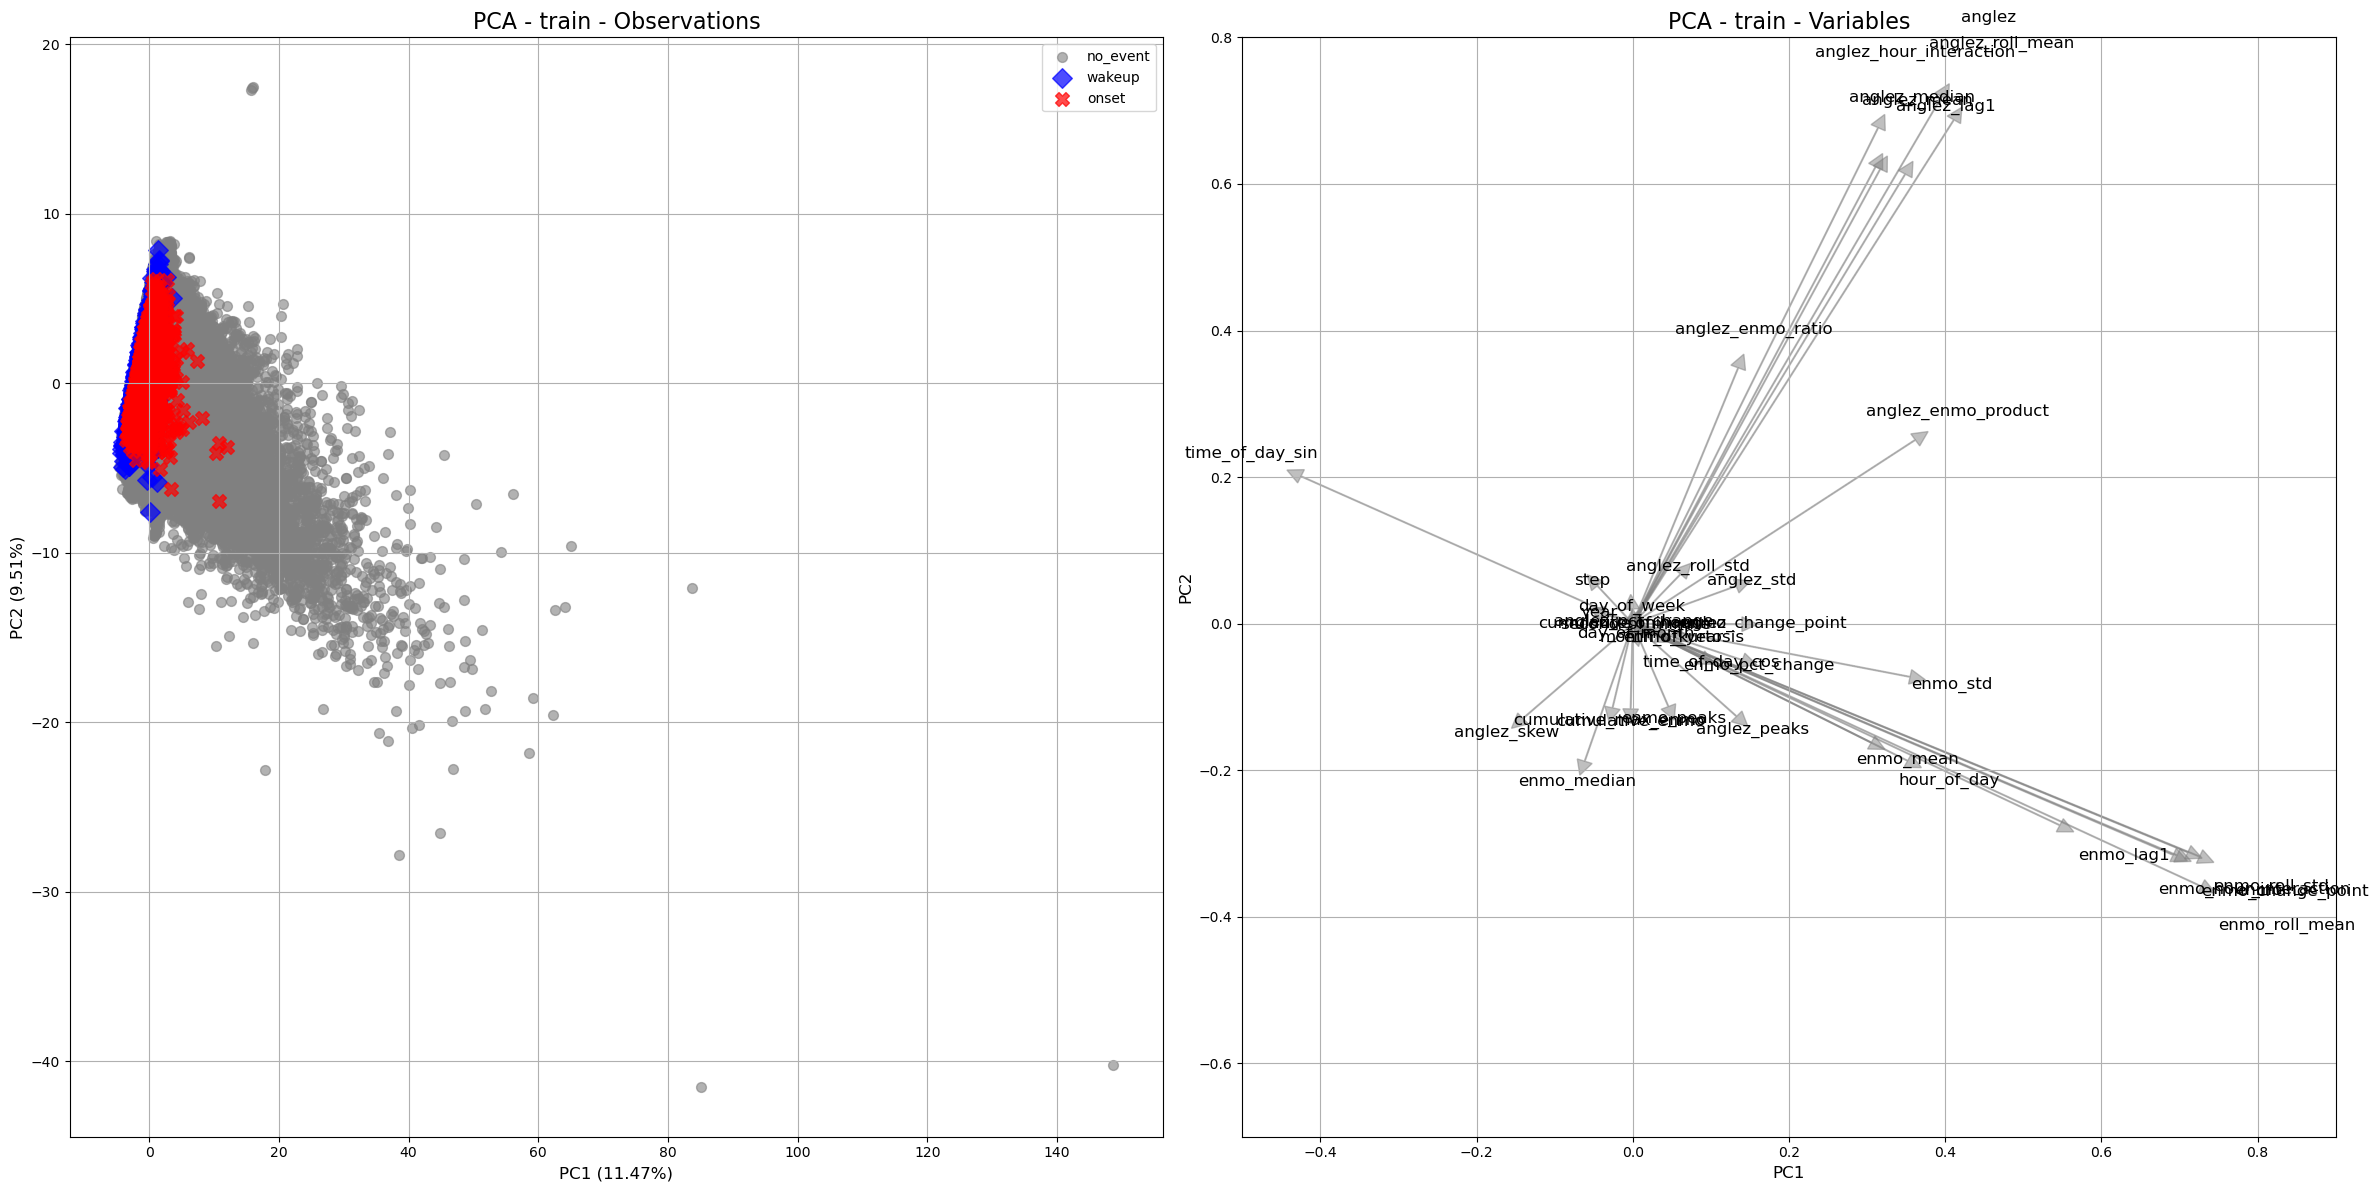

In [10]:
plot_pca(df)

In [11]:
df.to_csv('data/features_train_series.csv', index=False)

## Check if train and test data are balanced

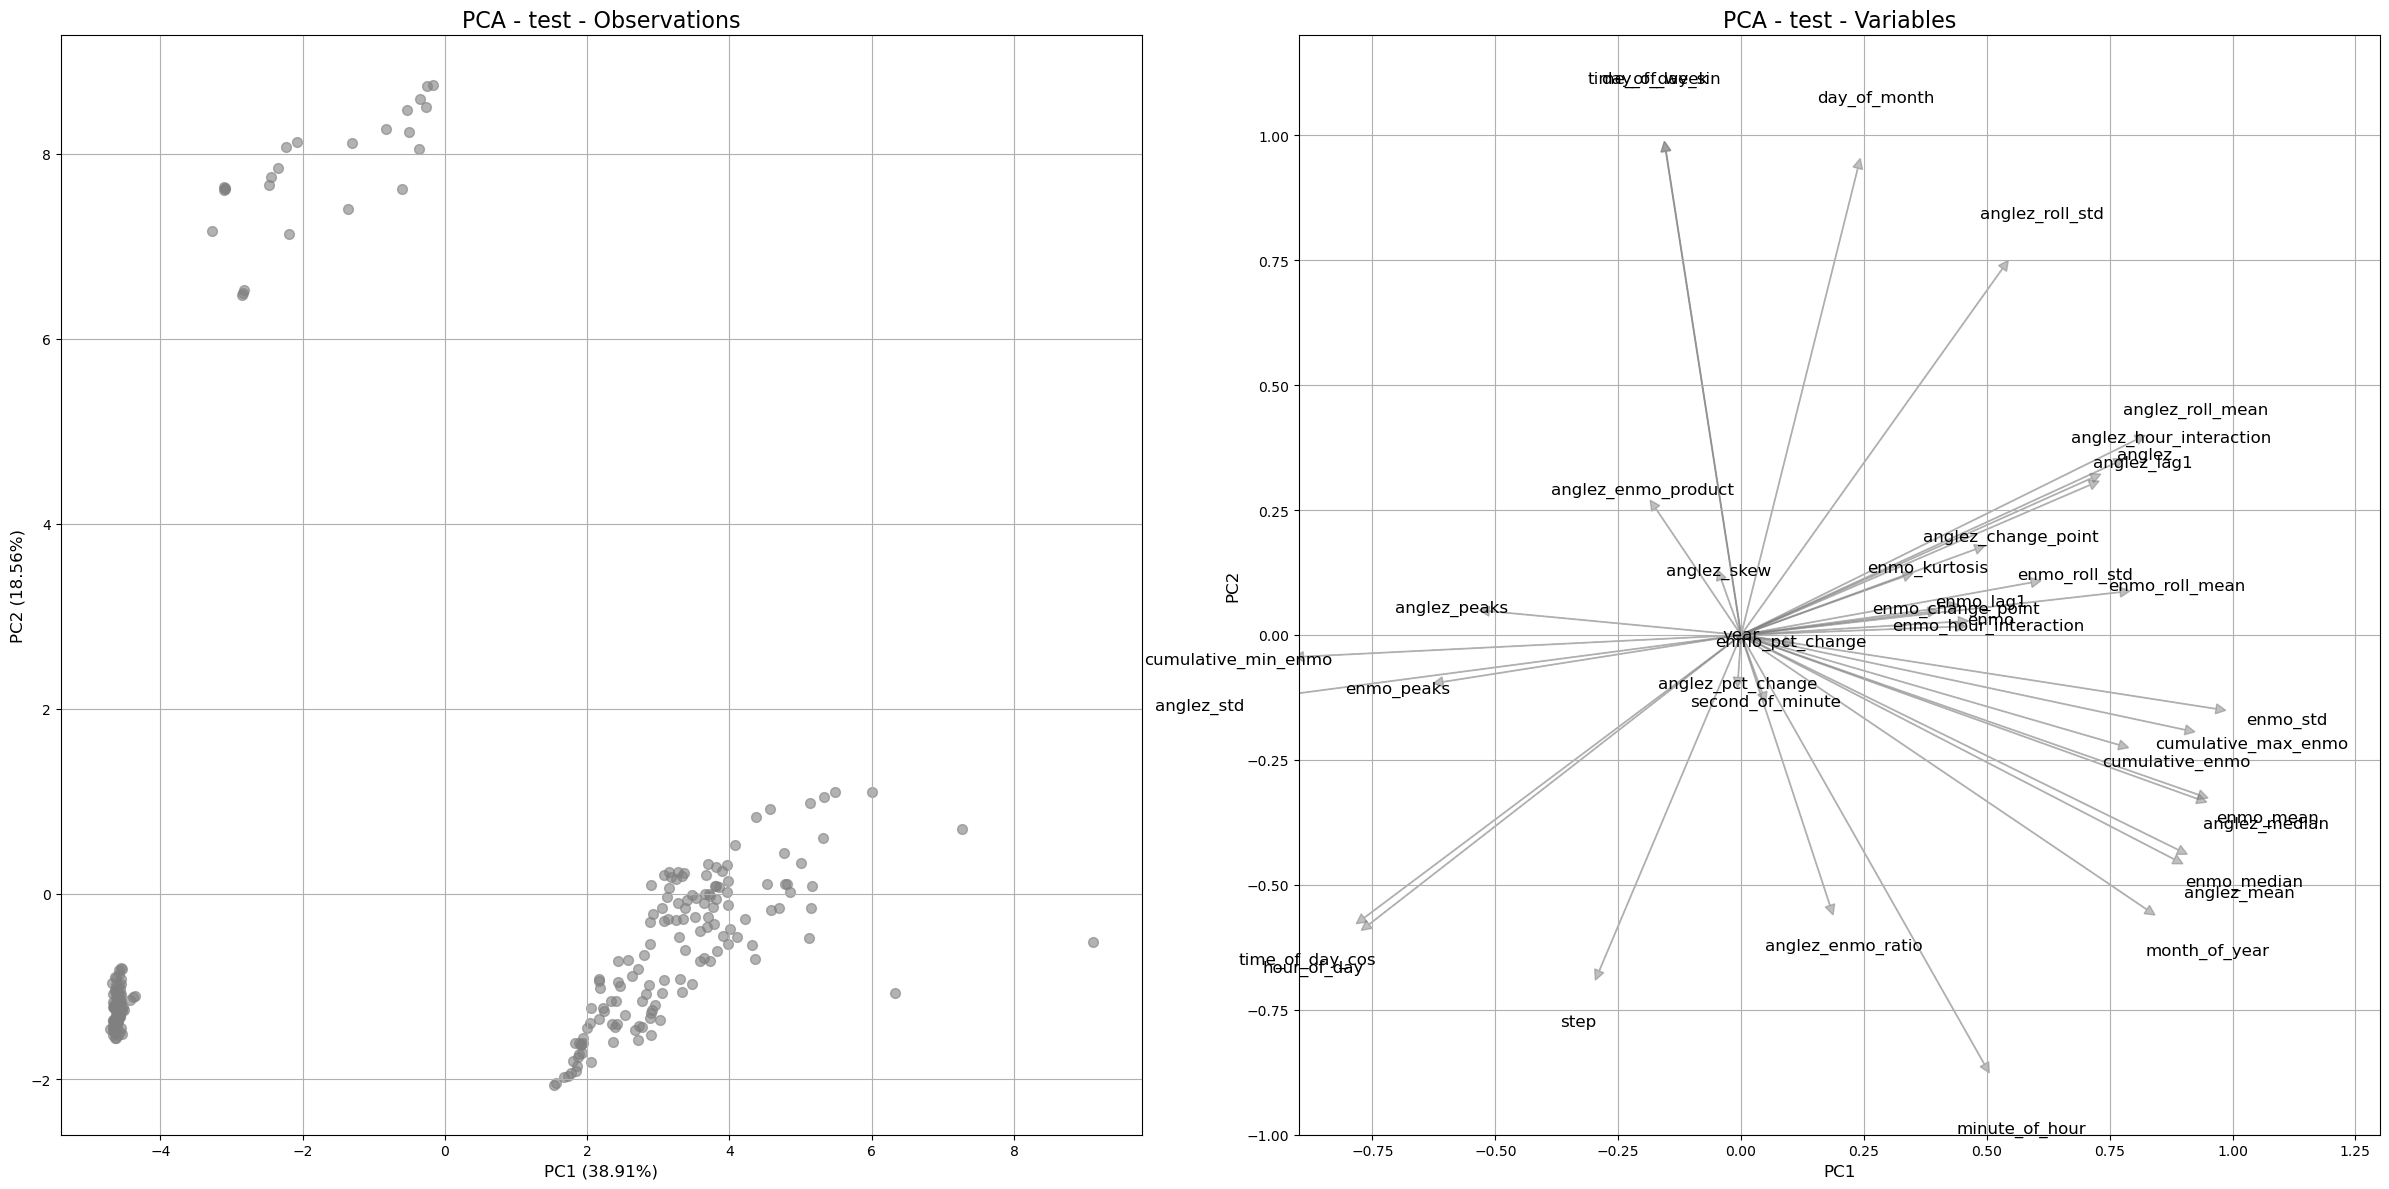

In [12]:
df_train = pd.read_csv('data/features_train_series.csv')
df_test = pd.read_parquet('data/test_series.parquet')

df_test = df_test.sort_values(by=['series_id', 'timestamp'])
df_test = add_features(df_test)
df_test = df_test.replace([np.inf, -np.inf], np.nan).dropna()

# Plot PCA for test data 

X = df_test.drop(columns=['series_id'])
feature_names = X.columns

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_ * 100

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'])
loadings_df['Variable'] = feature_names

# Create a DataFrame for observations
scores_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

### Subplot 1: Observations ###
axes[0].set_title('PCA - test - Observations', fontsize=16)
axes[0].scatter(scores_df['PC1'], scores_df['PC2'], 
                alpha=0.6, s=50, c='grey')
axes[0].set_xlabel(f'PC1 ({explained_variance[0]:.2f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({explained_variance[1]:.2f}%)', fontsize=12)
axes[0].grid()

### Subplot 2: Variables ###
axes[1].set_title('PCA - test - Variables', fontsize=16)
for i in range(loadings_df.shape[0]):
    axes[1].arrow(0, 0, loadings_df.loc[i, 'PC1'], 
                loadings_df.loc[i, 'PC2'],
                color='grey', alpha=0.5, head_width=0.02, head_length=0.02)
    axes[1].text(loadings_df.loc[i, 'PC1']*1.15, 
                loadings_df.loc[i, 'PC2']*1.15,
                loadings_df.loc[i, 'Variable'], 
                color='black', ha='center', va='center', fontsize=12)

axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].grid()
axes[1].set_ylim(-1.0, 1.2)
axes[1].set_xlim(-0.9, 1.3)

plt.tight_layout()
plt.show()


In [13]:
df_test.to_csv('data/features_test_series.csv', index=False)

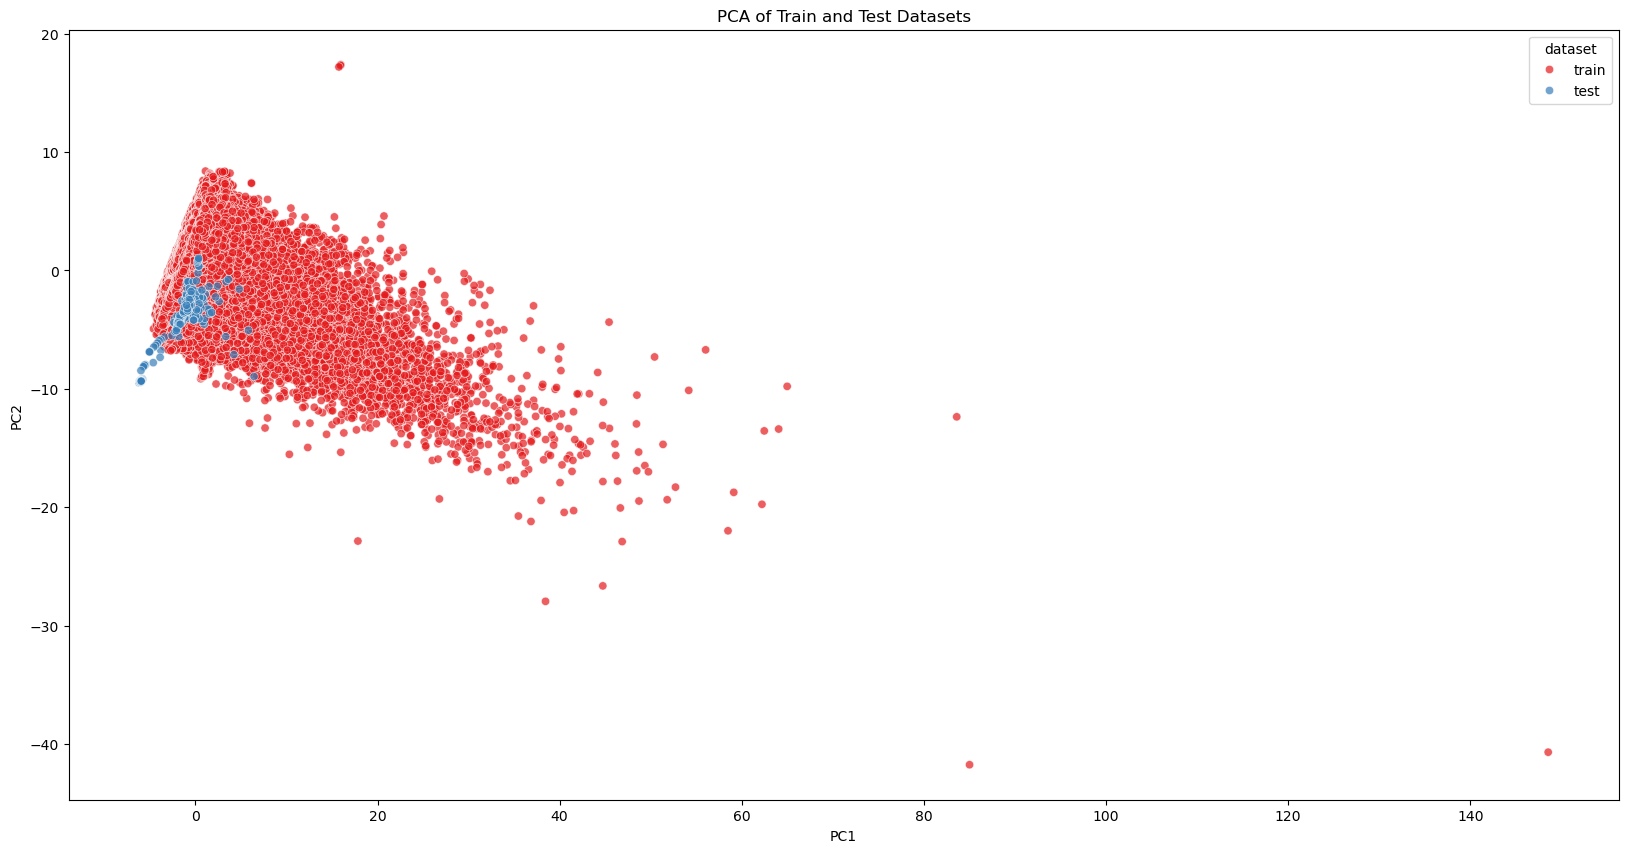

: 

In [14]:
# PCA of Train and Test Datasets

df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Drop non-feature columns (like 'dataset') before applying PCA
X = df_combined.drop(columns=['dataset', 'event', 'series_id'])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['dataset'] = df_combined['dataset']

# Plot the PCA results
plt.figure(figsize=(20, 10))
sns.scatterplot(x='PC1', y='PC2', hue='dataset', data=df_pca, palette='Set1', alpha=0.7)
plt.title('PCA of Train and Test Datasets')
plt.show()